In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from IPython.display import clear_output
from keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler

import segmentation_utils as su

In [10]:
ORIGINAL_PATH ='./database/'
TILE_PATH = './tile_database/'

TILE_SIZE = 256
STEP = int(TILE_SIZE/4)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

CLASSES = {0 : 'background',
           1 : 'Mucosa',
           2 : 'Linfocitos',
           3 : 'Submucosa',
           4 : 'Muscular',
           5 : 'Subserosa',
          }

BACKBONE = 'resnet34'

# Tile generating (uncomment only if needed)

## Get generators

In [7]:
scaler = MinMaxScaler()
preprocess_input = sm.get_preprocessing(BACKBONE)

#This function must be adapted for the used masks 
def preproces_data(img, mask):
    #img = (img.astype('float32')) / 255.
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    
    #
    #set mask colors as labels, notice coherente with the CLASS dict        
    mask=np.where(mask==225, 1, mask) #mucosa=1      #backgroud=0
    mask=np.where(mask==178, 2, mask) #linfocitos=2
    mask=np.where(mask==96,  3, mask) #submucosa=3
    mask=np.where(mask==131, 4, mask) #muscular=4
    mask=np.where(mask==105, 5, mask) #subserosa=5
    #Transform 1 channel labels to hot encoded
    mask = tf.keras.utils.to_categorical(mask, num_classes=NUM_CLASSES)
    return (img, mask)

# Get the generators
train_generator=su.get_generator_from_directory(TILE_PATH, mode='training',
                                                preprocess_function=preprocess_data, 
                                                augmentation=True, val_split=0.2, batch_size=32)
# Validation data should never be augmented
val_generator=su.get_generator_from_directory(TILE_PATH, mode='validation', 
                                              preprocess_function=preprocess_data, 
                                              augmentation=False, val_split=0.2, batch_size=32)

# Check loaded images

Images is shape (32, 256, 256, 3)
Masks is shape (32, 256, 256, 6) and has values [0. 1.]
Detected 6 classes for plotting


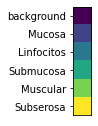

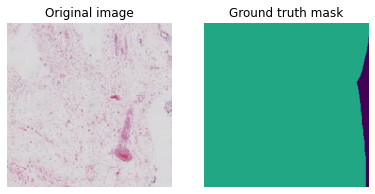

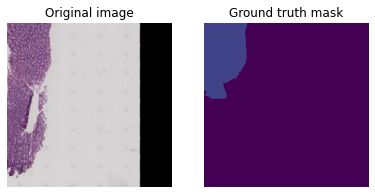

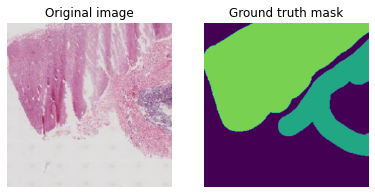

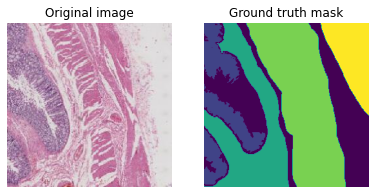

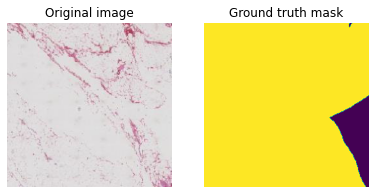

In [12]:
images, masks = train_generator.__next__()
val_images, val_masks = val_generator.__next__()

#print('Detected', len(images), 'images for training and', len(val_images), 'images for validation')
print('Images is shape', images.shape)
print('Masks is shape', masks.shape, 'and has values', np.unique(masks))

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
su.plot_legend(CLASSES)
su.plot_mask(images, one_channel_masks, num_plots=5)


## Prepare U-net model

In [17]:
# without these lines segmentation_models raises an error
sm.set_framework('tf.keras')
sm.framework()

#class_weights = [0.21, 2.60, 2.93, 2.52, 69.97, 5.36]
class_weights = [0.22, 2.69, 2.85, 2.39, 109.98, 3.91]
#class_weights = su.get_class_weights(TRAIN_PATH+'masks/img')
print('Class weights:', class_weights)

dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS = dice_loss + (1 * focal_loss)
METRICS = metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',
                classes=NUM_CLASSES, 
                activation='softmax',
                #encoder_freeze=True
               )

OPTIMIZER = tf.keras.optimizers.Adam(0.0001)
model.compile(OPTIMIZER, 
              loss=TOTAL_LOSS,
              metrics=METRICS)
#model.summary()    #print the model structure


# This class is used by model.fet to print a prediction at the end of every epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        images, masks = val_generator.__next__()
        predictions = model.predict(images[0:5])
        one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
        one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel
        su.plot_prediction(images, one_channel_masks, one_channel_predictions)


Class weights: [0.22, 2.69, 2.85, 2.39, 109.98, 3.91]


## Train model


Sample Prediction after epoch 3

Detected 6 classes for plotting


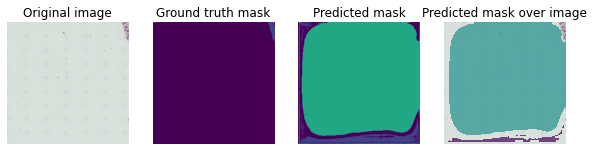

Epoch 4/100
46/50 [==========================>...] - ETA: 1s - loss: -17.1164 - iou_score: 0.3761 - f1-score: 0.4621

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=50,
                    validation_data=val_generator,
                    validation_steps=50,
                    callbacks=[DisplayCallback()]
                   )
model.save('./resources/tiled_unet.hdf5')

## Evaluate model

In [ ]:
#import pandas as pd
#hist_df = pd.DataFrame(history.history) 
#hist_csv_file = 'history_unet_50epochs.csv'
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)
    
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

max_iou = max(val_acc)
print ("Maximum accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum accuracy reached at epoch: ",max_index+1)

In [ ]:
#model = load_model('./resources/tiled_unet.hdf5', compile=False)

test_images, test_masks = val_generator.__next__()
prediction=model.predict(test_images)

test_masks = np.argmax(test_masks, axis=3) #from hot encoded to 1 channel
prediction=np.argmax(prediction, axis=3)

IOU = MeanIoU(num_classes=NUM_CLASSES)  
#compare groun truth and predicted masks
IOU.update_state(test_masks, prediction)

#calculate I0U for each class...
values = np.array(IOU.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)

#IoU = true positive / (true positive +
#                       false poitives (same row) +
#                       false negatives (same column))
class0_IoU = values[0,0] / (values[0,0] +
                            values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] +
                            values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])

class1_IoU = values[1,1] / (values[1,1] +
                            values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] +
                            values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])

class2_IoU = values[2,2] / (values[2,2] +
                            values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] +
                            values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])

class3_IoU = values[3,3] / (values[3,3] +
                            values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] +
                            values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])

class4_IoU = values[4,4] / (values[4,4] +
                            values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] +
                            values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])

class5_IoU = values[5,5] / (values[5,5] +
                            values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] +
                            values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("Mean IoU using Unet =", IOU.result().numpy())
print('IoU for',CLASSES[0],'is:', class0_IoU)
print('IoU for',CLASSES[1],'is:', class1_IoU)
print('IoU for',CLASSES[2],'is:', class2_IoU)
print('IoU for',CLASSES[3],'is:', class3_IoU)
print('IoU for',CLASSES[4],'is:', class4_IoU)
print('IoU for',CLASSES[5],'is:', class5_IoU)
with np.printoptions(suppress=True):
    print('\n', values)

#with np.printoptions(threshold=np.inf):
#    print(test_masks[0])

su.plot_prediction(test_images, test_masks, prediction)

## Plots tests

In [ ]:

images, masks = val_images[10:20], val_masks[10:20]
predictions = model.predict(images)
one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel
su.plot_prediction(images, one_channel_masks, one_channel_predictions, num_plots=5)

In [ ]:
from patchify import unpatchify

images = get_images('../DB/test/images/img/', TILE_SIZE, step=int(TILE_SIZE))
no_cat_masks = get_masks('../DB/test/masks/img/', TILE_SIZE, step=int(TILE_SIZE), print_size=True)
masks, num_classes = masks_to_categorical(no_cat_masks)
predictions = model.predict(images)

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel

reshaped_img = np.reshape(images, [5, 4, 1, TILE_SIZE, TILE_SIZE, 3])
reshaped_mask = np.reshape(one_channel_masks, [5, 4, TILE_SIZE, TILE_SIZE])
reshaped_pred = np.reshape(one_channel_predictions, [5, 4, TILE_SIZE, TILE_SIZE])

reconstructed_img = unpatchify(reshaped_img, ( 1280, 1024, 3))
reconstructed_mask = unpatchify(reshaped_mask, ( 1280, 1024))
reconstructed_pred = unpatchify(reshaped_pred, ( 1280, 1024))

cmap='viridis'

f = plt.figure(figsize = (20, 20))
f.add_subplot(1,4,1)
plt.axis('off')
plt. title('Original image')
plt.imshow(reconstructed_img)
f.add_subplot(1,4,2)
plt.axis('off')
plt. title('Ground truth mask')
plt.imshow(reconstructed_mask, cmap=cmap)
f.add_subplot(1,4,3)
plt.axis('off')
plt. title('Predicted mask')
plt.imshow(reconstructed_pred, cmap=cmap)
f.add_subplot(1,4,4)
plt.axis('off')
plt. title('Predicted mask over image')
plt.imshow(reconstructed_img)
no_background_predictions = np.ma.masked_where(reconstructed_pred == 0, reconstructed_pred) # remove background(0) from prediction
plt.imshow(no_background_predictions, cmap=cmap, alpha=0.7)
plt.show(block=True)
plt.show


In [ ]:
from patchify import unpatchify

print((1024 - TILE_SIZE) % (TILE_SIZE/2))

images = get_images('../DB/test/images/img/', TILE_SIZE, step=int(TILE_SIZE/2))
no_cat_masks = get_masks('../DB/test/masks/img/', TILE_SIZE, step=int(TILE_SIZE/2), print_size=True)
masks, num_classes = masks_to_categorical(no_cat_masks)
predictions = model.predict(images)

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel

reshaped_img = np.reshape(images, [9, 7, 1, TILE_SIZE, TILE_SIZE, 3])
reshaped_mask = np.reshape(one_channel_masks, [9, 7, TILE_SIZE, TILE_SIZE])
reshaped_pred = np.reshape(one_channel_predictions, [9, 7, TILE_SIZE, TILE_SIZE])

reconstructed_img = unpatchify(reshaped_img, ( 1280, 1024, 3))
reconstructed_mask = unpatchify(reshaped_mask, ( 1280, 1024))
reconstructed_pred = unpatchify(reshaped_pred, ( 1280, 1024))

cmap='viridis'

f = plt.figure(figsize = (20, 20))
f.add_subplot(1,4,1)
plt.axis('off')
plt. title('Original image')
plt.imshow(reconstructed_img)
f.add_subplot(1,4,2)
plt.axis('off')
plt. title('Ground truth mask')
plt.imshow(reconstructed_mask, cmap=cmap)
f.add_subplot(1,4,3)
plt.axis('off')
plt. title('Predicted mask')
plt.imshow(reconstructed_pred, cmap=cmap)
f.add_subplot(1,4,4)
plt.axis('off')
plt. title('Predicted mask over image')
plt.imshow(reconstructed_img)
no_background_predictions = np.ma.masked_where(reconstructed_pred == 0, reconstructed_pred) # remove background(0) from prediction
plt.imshow(no_background_predictions, cmap=cmap, alpha=0.99)
plt.show(block=True)
plt.show


In [ ]:
from patchify import unpatchify

print((1024 - TILE_SIZE) % (TILE_SIZE/8))

images = get_images('../DB/test/images/img/', TILE_SIZE, step=int(TILE_SIZE/8))
no_cat_masks = get_masks('../DB/test/masks/img/', TILE_SIZE, step=int(TILE_SIZE/8), print_size=True)
masks, num_classes = masks_to_categorical(no_cat_masks)
predictions = model.predict(images)

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel

reshaped_img = np.reshape(images, [33, 25, 1, TILE_SIZE, TILE_SIZE, 3])
reshaped_mask = np.reshape(one_channel_masks, [33, 25, TILE_SIZE, TILE_SIZE])
reshaped_pred = np.reshape(one_channel_predictions, [33, 25, TILE_SIZE, TILE_SIZE])

reconstructed_img = unpatchify(reshaped_img, ( 1280, 1024, 3))
reconstructed_mask = unpatchify(reshaped_mask, ( 1280, 1024))
reconstructed_pred = unpatchify(reshaped_pred, ( 1280, 1024))

cmap='viridis'

f = plt.figure(figsize = (20, 20))
f.add_subplot(1,4,1)
plt.axis('off')
plt. title('Original image')
plt.imshow(reconstructed_img)
f.add_subplot(1,4,2)
plt.axis('off')
plt. title('Ground truth mask')
plt.imshow(reconstructed_mask, cmap=cmap)
f.add_subplot(1,4,3)
plt.axis('off')
plt. title('Predicted mask')
plt.imshow(reconstructed_pred, cmap=cmap)
f.add_subplot(1,4,4)
plt.axis('off')
plt. title('Predicted mask over image')
plt.imshow(reconstructed_img)
no_background_predictions = np.ma.masked_where(reconstructed_pred == 0, reconstructed_pred) # remove background(0) from prediction
plt.imshow(no_background_predictions, cmap=cmap, alpha=0.7)
plt.show(block=True)
plt.show
